In [30]:
from htm.algorithms import TemporalMemory
from htm.bindings.sdr import SDR
import numpy as np
import matplotlib.pyplot as plt
from htm_rl.modules.htm.spatial_pooler import UnionTemporalPooler

In [21]:
def make_sdr(pos: tuple, _shape: tuple) -> SDR:
    result = SDR(_shape)
    numpy_res = result.dense
    numpy_res = np.zeros(_shape)
    numpy_res[pos] = 1
    result.dense = numpy_res
    return result

def make_sdrs(array: np.ndarray, _shape: tuple) -> np.ndarray:
    result = np.ndarray((array.size,), dtype=SDR)
    iterator = 0
    for number in array:
        result[iterator] = make_sdr(number, _shape)
        iterator += 1
    return result

def learn_model(tm: TemporalMemory, sdrs: np.ndarray, num_epochs=10) -> list:
    errors = []
    for epoch in range(num_epochs):
        for sdr in sdrs:
            tm.compute(sdr, learn=True)
            tm.activateDendrites(True)
            errors.append(tm.anomaly)
        tm.compute(SDR(sdrs[0].dense.shape), learn=False)
    return errors

def generate_data(n, n_actions, n_states, randomness=1.0, seed=0):
    raw_data = list()
    np.random.seed(seed)
    seed_seq = np.random.randint(0, n_actions, n_states)
    raw_data.append(seed_seq.copy())
    n_replace = int(n_states * randomness)
    for i in range(1, n):
        new_seq = np.random.randint(0, n_actions, n_states)
        if randomness == 1.0:
            raw_data.append(new_seq)
        else:
            indices = np.random.randint(0, n_states, n_replace)
            seed_seq[indices] = new_seq[indices]
            raw_data.append(seed_seq.copy())
    data = [list(zip(range(n_states), x)) for x in raw_data]
    return raw_data, data


In [15]:
shape = (4,)
cells_per_col = 4

row_data, data = generate_data(4, shape[0], 10)
print(f'row: {row_data[:1]}\n')
print(f'data: {data[:1]}\n')

row: [array([0, 3, 1, 0, 3, 3, 3, 3, 1, 3])]

data: [[(0, 0), (1, 3), (2, 1), (3, 0), (4, 3), (5, 3), (6, 3), (7, 3), (8, 1), (9, 3)]]



In [16]:
tm = TemporalMemory(
    columnDimensions=shape,
    cellsPerColumn=cells_per_col,
    minThreshold=1,
    activationThreshold=1,
)

sdrs = make_sdrs(row_data[0], shape)
print(sdrs[1])

SDR( 4 ) 3


In [25]:
errors = learn_model(tm, sdrs)
print(errors)

[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]


Text(0.5, 1.0, 'tm_train_errors')

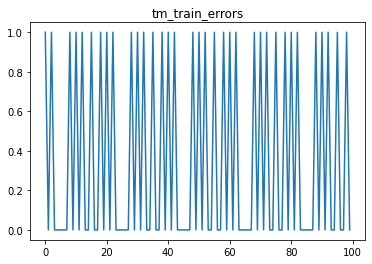

In [29]:
plt.plot(range(len(errors)), errors)
plt.title('tm_train_errors')

In [33]:
tp = UnionTemporalPooler(
    activeOverlapWeight=1.0,
    predictedActiveOverlapWeight=1.0,
    seed=42
)